# Calculate CMIP Indeces

This file 
1. calculates all the 'traditional' indeces defined in utils/_indexDefinitions for all months for all models.
2. it then averages the result over the warm season
3. and figures out what years there are compounding events



In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound


In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
modelSet=_model.scenarioMip

In [5]:
experimentSet=['piControl','ssp585']

# 1. Calculate CMIP Indeces

For each experiment and model, calculate indices

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [6]:
varsToDetrend=[
    'dmi',
    'eastIO',
    'nino34',
    'westIO',
    'nino4',
    #'samWinter',
    #'samSummer'
]

In [7]:
for experiment in experimentSet:
    timePIndeces=list()

    for model in _model.scenarioMip[:,1]:
        #try:
            indecesDs = xarray.open_dataset('results/cmipMonthlyIndeces/' + model +'tos'+ experiment + '.nc')
            indecesDs['model']=model
            indecesDs=indecesDs.set_coords({'model':model})
            
            seasonAv=tp.averageForTimePeriod(indecesDs)
            seasonAv['dmiNoDetrend']=seasonAv.dmi
            
            for iVar in varsToDetrend:
                seasonAv[iVar]=(
                    seasonAv[iVar+'NoDetrend']
                    -seasonAv[iVar+'NoDetrend'].rolling(
                        year=11,min_periods=5,center=True
                    ).mean('year')
                )
                
            timePIndeces.append(
                seasonAv
            )
        #except Exception as e:
        #    print('skipping' + model + experiment) 
            
    results=xarray.concat(timePIndeces, 'model')
    results.to_netcdf('results/cmip6'+experiment+'TradIndecesTos.nc')


In [8]:
results

<xarray.Dataset>
Dimensions:                 (model: 37, year: 450)
Coordinates:
  * year                    (year) int64 1850 1851 1852 1853 ... 2297 2298 2299
  * model                   (model) <U16 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/14)
    westIONoDetrend         (model, year) float64 -0.1756 0.1422 ... nan nan
    nino4                   (model, year) float64 -0.4306 0.2568 ... nan nan
    westIO                  (model, year) float64 -0.3015 0.02516 ... nan nan
    backgroundSstNoDetrend  (model, year) float64 -0.224 0.05919 ... nan nan
    dmi                     (model, year) float64 0.1778 -0.3087 ... nan nan
    eastIONoDetrend         (model, year) float64 -0.7739 0.1518 ... nan nan
    ...                      ...
    nino34                  (model, year) float64 -0.6412 0.5291 ... nan nan
    eastIO                  (model, year) float64 -0.4793 0.3339 ... nan nan
    samWinter               (model, year) float64 -0.5221 -0.6108 ... nan nan
    nino4NoDetrend          (model, year) float64 -0.1826 0.4717 ... nan nan
    samSummer               (model, year) float64 -0.8385 -4.552 ... nan nan
    dmiNoDetrend            (model, year) float64 0.5983 -0.009583 ... nan nan

Some sanity checks to see if it looks ok:


In [9]:
results=xarray.open_dataset('results/cmip6ssp585TradIndecesTos.nc').sel(year=slice(1850,2099))

In [10]:
str(results.isel(model=6).model.values)

'CESM2'

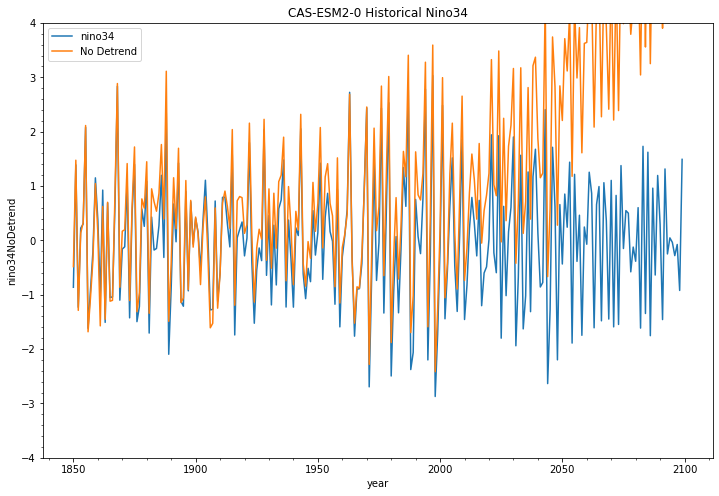

In [11]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

results.isel(model=6).nino34.plot(label='nino34')
results.isel(model=6).nino34NoDetrend.plot(label='No Detrend')

#Tidy up a bit
plt.title(str(results.isel(model=5).model.values) + " Historical Nino34")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [12]:
# A multi-model mean?

wMean = results.samWinter.mean(dim='model')
wStd = results.samWinter.std(dim='model')

In [13]:
sMean = results.samSummer.mean(dim='model')
sStd = results.samSummer.std(dim='model')

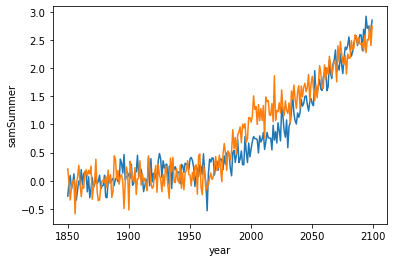

In [14]:
plt.figure()
wMean.plot()
sMean.plot()



In [15]:
piControlXr=xarray.open_dataset('results/cmip6piControlTradIndecesTos.nc')

In [16]:
# This should calculate stds for all experiments and all indeces
stdXr = piControlXr.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaXr= xarray.merge(
    (stdXr[['nino34','dmi']], stdXr['samSummer']/2)
)

In [17]:
criteriaXr

<xarray.Dataset>
Dimensions:    (model: 37)
Coordinates:
  * model      (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    nino34     (model) float64 0.8416 0.7078 0.8296 0.9683 ... 1.341 1.222 0.931
    dmi        (model) float64 0.4438 0.6644 0.2348 ... 0.5571 0.4919 0.5917
    samSummer  (model) float64 0.6323 0.6126 0.548 ... 0.5571 0.5387 0.5739

# Plot time trends

For comparison, also load the observational results

In [18]:
obsXr=xarray.open_dataset('results/obsIndeces.nc')

In [19]:
obsXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables: (12/16)
    nino4                   (year) float64 ...
    backgroundSstNoDetrend  (year) float64 ...
    nino3                   (year) float64 ...
    dmi                     (year) float64 ...
    nino34NoDetrend         (year) float64 ...
    westIO                  (year) float64 ...
    ...                      ...
    eastIO                  (year) float64 ...
    cIndex                  (year) float64 ...
    eIndex                  (year) float64 ...
    samSummer               (year) float64 ...
    samWinter               (year) float64 ...
    dmiNoDetrend            (year) float64 ...

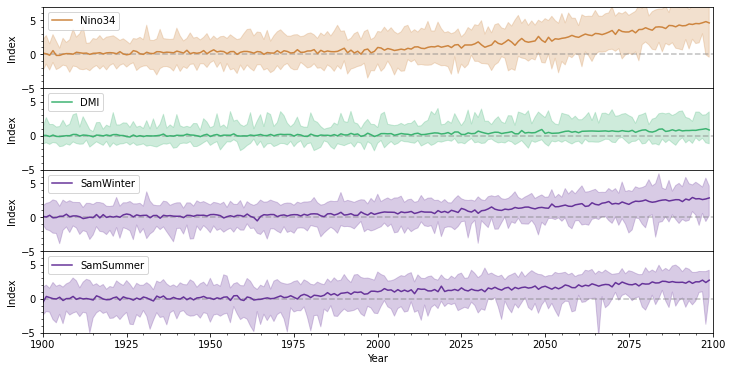

In [20]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34NoDetrend', 'dmiNoDetrend', 'samWinter', 'samSummer']
labels = ['Nino34', 'DMI', 'SamWinter', 'SamSummer']
colors = ['peru', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4], [-4,4]]

fig = plt.figure(figsize=(12,6))

for i in range(4):

    #create a subplot (row, column, size)
    ax=fig.add_subplot(4,1,i+1)

    # plot the actual data
    plotData=results[indexToPlot[i]]

    #blue line for multi-experiment mean, and light blue shading between min and max
    plt.plot(
        plotData.year, 
        plotData.mean('model').values, 
        label=labels[i], 
        color=colors[i]
    )
    plt.legend(loc='upper left')
    
    #obsXr[indexToPlot[i]].plot(alpha=0.5, linestyle='-')
    
    plt.fill_between(
        plotData.year, plotData.min('model').values, plotData.max('model').values, 
                     color=colors[i], alpha=0.25
    )
    plt.xlim([1900,2100])
    plt.ylim([-5,7])
    plt.minorticks_on()
    plt.ylabel('Index')
    plt.xlabel('')
    ax.xaxis.set_visible(False)
    plt.hlines(0,1900,2100, color='grey', linestyles='dashed', alpha=0.5)

    
plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
ax.xaxis.set_visible(True)

plt.savefig('results/cmip6IndexTrends.pdf')


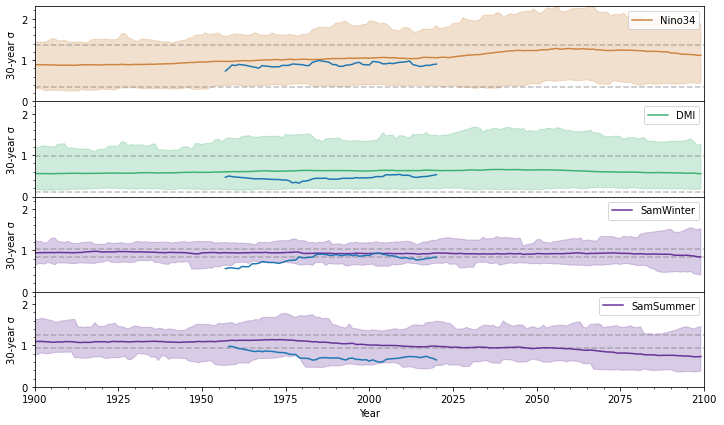

In [41]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34NoDetrend', 'dmiNoDetrend', 'samWinter', 'samSummer']
labels = ['Nino34', 'DMI', 'SamWinter', 'SamSummer']
colors = ['peru', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4], [-4,4]]

fig = plt.figure(figsize=(12,7))

for i in range(4):

    #create a subplot (row, column, size)
    ax=fig.add_subplot(4,1,i+1)

    # plot the actual data
    plotData=results[indexToPlot[i]]

    #blue line for multi-experiment mean, and light blue shading between min and max
    plt.plot(
        plotData.year, 
        (plotData.rolling(year=30, min_periods=15, center=True).std('year')).mean('model').values, 
        label=labels[i], 
        color=colors[i]
    )
    plt.legend(loc='upper right')
    
    obsXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').plot()
    
    plt.fill_between(
        plotData.year, 
        plotData.rolling(year=30, min_periods=15, center=True).std('year').min('model').values,
        plotData.rolling(year=30, min_periods=15, center=True).std('year').max('model').values, 
                     color=colors[i], alpha=0.25
    )
    
    
    piMean=piControlXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').mean()
    piStd=piControlXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').mean('year').std('model')

    plt.hlines([piMean+1.96*piStd,piMean-1.96*piStd],1900,2100, color='grey', linestyles='dashed', alpha=0.5)
    

    
    plt.ylim([0,2.3])
    plt.yticks([0,1,2])
    plt.xlim([1900,2100])
    plt.minorticks_on()
    plt.ylabel('30-year σ')
    plt.xlabel('')
    ax.xaxis.set_visible(False)
    
    
plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
ax.xaxis.set_visible(True)

plt.savefig('results/cmip6IndexStdTrends.pdf')


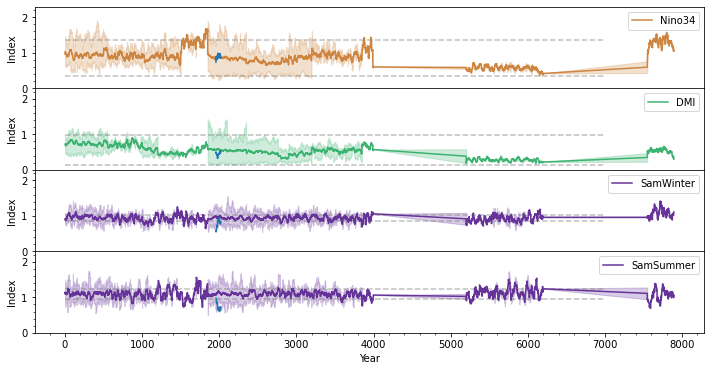

In [33]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34NoDetrend', 'dmiNoDetrend', 'samWinter', 'samSummer']
labels = ['Nino34', 'DMI', 'SamWinter', 'SamSummer']
colors = ['peru', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4], [-4,4]]

fig = plt.figure(figsize=(12,6))

for i in range(4):

    #create a subplot (row, column, size)
    ax=fig.add_subplot(4,1,i+1)

    # plot the actual data
    plotData=piControlXr[indexToPlot[i]]

    #blue line for multi-experiment mean, and light blue shading between min and max
    plt.plot(
        plotData.year, 
        (plotData.rolling(year=30, min_periods=15, center=True).std('year')).mean('model').values, 
        label=labels[i], 
        color=colors[i]
    )
    plt.legend(loc='upper right')
    
    obsXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').plot()
    
    plt.fill_between(
        plotData.year, 
        plotData.rolling(year=30, min_periods=15, center=True).std('year').min('model').values,
        plotData.rolling(year=30, min_periods=15, center=True).std('year').max('model').values, 
                     color=colors[i], alpha=0.25
    )
    
    
    piMean=piControlXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').mean()
    piStd=piControlXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').mean('year').std('model')

    plt.hlines([piMean+1.96*piStd,piMean-1.96*piStd],0,7000, color='grey', linestyles='dashed', alpha=0.5)
    

    
    plt.ylim([0,2.3])
    plt.yticks([0,1,2])
    #plt.xlim([1900,2100])
    plt.minorticks_on()
    plt.ylabel('Index')
    plt.xlabel('')
    ax.xaxis.set_visible(False)
    
    
plt.subplots_adjust(hspace=0)
plt.xlabel('Year')
ax.xaxis.set_visible(True)



In [34]:
piControlXr[indexToPlot[i]].rolling(year=30, min_periods=15, center=True).std('year').mean('year')

<xarray.DataArray 'samSummer' (model: 37)>
array([1.23519895, 1.18544395, 1.05993907, 1.09120085, 1.05389527,
       1.27894636, 1.03150733, 1.04607123, 1.02670051, 0.93213112,
       1.03485015, 1.1179165 , 1.12872778, 1.13647641, 1.16336825,
       1.00082137, 0.99766341, 1.01625143, 1.09989902, 1.07971513,
       1.02472292, 1.06179719, 1.15719838, 1.0779017 , 0.9400117 ,
       1.12036709, 1.13740555, 1.05309376, 1.1493548 , 1.01645283,
       1.12158136, 1.22088543, 1.15006179, 0.99595028, 1.07363952,
       1.0434745 , 1.115628  ])
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

# ENSO Contamination with Global Warming signal

In [22]:
results

<xarray.Dataset>
Dimensions:                 (model: 37, year: 250)
Coordinates:
  * year                    (year) int64 1850 1851 1852 1853 ... 2097 2098 2099
  * model                   (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/14)
    westIONoDetrend         (model, year) float64 ...
    nino4                   (model, year) float64 ...
    westIO                  (model, year) float64 ...
    backgroundSstNoDetrend  (model, year) float64 ...
    dmi                     (model, year) float64 ...
    eastIONoDetrend         (model, year) float64 ...
    ...                      ...
    nino34                  (model, year) float64 ...
    eastIO                  (model, year) float64 ...
    samWinter               (model, year) float64 -0.5221 -0.6108 ... 4.613
    nino4NoDetrend          (model, year) float64 ...
    samSummer               (model, year) float64 -0.8385 -4.552 ... 4.008 3.919
    dmiNoDetrend            (model, year) float64 0.5983 -0.009583 ... 1.012

In [23]:
%run utils/emergence.ipynb

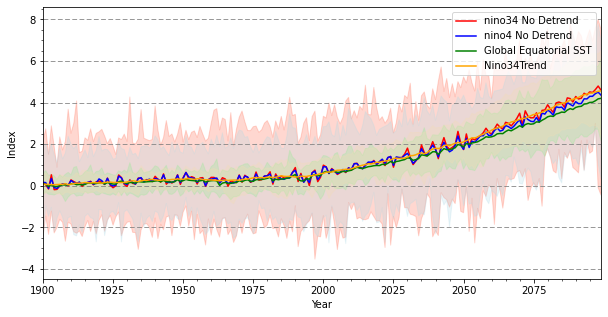

In [24]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        results[['nino34NoDetrend','nino4NoDetrend','backgroundSstNoDetrend']],
        results['nino34NoDetrend'].rolling(year=11,center=True,min_periods=5).mean('year').rename('nino34Trend')
    ])
)

plt.ylabel('Index')
#plt.ylim([-2,2])
plt.xlim([1900,2099])
plt.grid(axis='y', color='grey', dashes=[6,3])
plt.legend(['nino34 No Detrend', 'nino4 No Detrend', 'Global Equatorial SST', 'Nino34Trend'])
#plt.savefig('results/dmiVsEastIO.png')

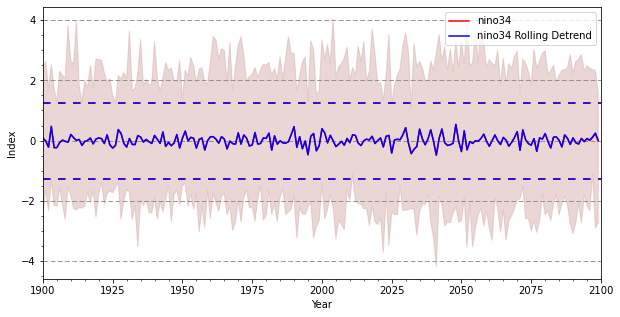

In [25]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        results['nino34'],
        (
            results['nino34NoDetrend']
            -results['nino34NoDetrend'].rolling(year=11,center=True,min_periods=5).mean('year')
        ).rename('nino34 Rolling Detrend')
    ]),
    xarray.merge([
        piControlXr['nino34'],
        (
            piControlXr['nino34NoDetrend']
            -piControlXr['nino34NoDetrend'].rolling(year=11,center=True,min_periods=5).mean('year')
        ).rename('nino34 Rolling Detrend')
    ])
)

plt.ylabel('Index')
#plt.ylim([-2,2])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])
#plt.legend(['nino34', 'nino34 Rolling DeTrend'])
#plt.savefig('results/dmiVsEastIO.png')

In [26]:
results.nino34RollingDetrend.mean('model').plot()
results.nino34.mean('model').plot()

AttributeError: 'Dataset' object has no attribute 'nino34RollingDetrend'

# IOD Western vs Eastern

In [ ]:
%run utils/emergence.ipynb

In [ ]:
overlaidEmergePlot(
    results[['dmi','eastIO']]
)

In [ ]:
overlaidEmergePlot(
    results.sel(year=slice(1850,2099)).dmiNoDetrend.rolling(year=30,center=True).std('year').to_dataset()
)

In [ ]:
for experiment in experimentSet:
    timePIndeces=list()

    for model in _model.scenarioMip[:,1]:
        try:
            indecesDs = xarray.open_dataset('results/cmipMonthlyIndeces/' + model +'tos'+ experiment + '.nc')
            indecesDs['model']=model
            timePIndeces.append(
                tp.averageForTimePeriod(
                    indecesDs[[
                        'dmi',
                        'eastIONoDetrend',
                        'westIONoDetrend', 
                        'backgroundSstNoDetrend', 
                        'westIO', 
                        'eastIO'
                    ]]
                ).sel(year=slice(1850,2099))
            )
        except Exception as e:
            print('skipping' + model + experiment) 
            
ioXr=xarray.concat(timePIndeces, 'model')




In [ ]:
ioXr

In [ ]:
overlaidEmergePlot(
    ioXr[['westIONoDetrend','eastIONoDetrend','backgroundSstNoDetrend']]
    #ioXr
)

plt.ylabel('Area Weighted Anomaly °C')
plt.xlim([1900,2100])
plt.legend(['Western IO', 'Eastern IO','Global Equatorial SST'])
plt.grid(axis='y', color='grey', dashes=[6,3])

plt.savefig('results/westVsEastIO.png')

In [ ]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        ioXr.dmi,
        #ioXr.eastIO*-1
    ]),
    #to make a baseline, use piContorl
    #xarray.merge([
    #    piControlXr.dmi,
    #    piControlXr.eastIO*-1
    #])
)

plt.ylabel('Index')
plt.ylim([-2,2])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])
plt.legend(['DMI'])#, 'Inverted Detrend Eastern IO'])
plt.savefig('results/dmiTrend.pdf')

In [ ]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        ioXr.dmi,
        ioXr.eastIO*-1,
        ioXr.westIO
    ]),
    #to make a baseline, use piContorl
    #xarray.merge([
    #    piControlXr.dmi,
    #    piControlXr.eastIO*-1
    #])
)

plt.ylabel('Index')
plt.ylim([-2,2])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])
#plt.legend(['DMI', 'Inverted Detrend Eastern IO'])


In [ ]:
ioXr.dmi.rolling(year=7,center=True).std('year').mean('model').plot()

In [ ]:
plt.scatter(ioXr.isel(model=5).eastIO,ioXr.isel(model=5).westIO)

In [ ]:
overlaidEmergePlot(
    # data of interest is the dmi and inverted eastern IO
    xarray.merge([
        ioXr.dmi,
        ioXr.eastIO*-1,
        ioXr.westIO
    ]).isel(model=5),
    #to make a baseline, use piContorl
    #xarray.merge([
    #    piControlXr.dmi,
    #    piControlXr.eastIO*-1
    #])
)

plt.ylabel('Index')
plt.ylim([-2,2])
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])
#plt.legend(['DMI', 'Inverted Detrend Eastern IO'])
